# Time Frequency Analysis via Basis Pursuit

We implement the example given in [Steven Boyd's _convex optimization_ book](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf) §6.5.4, pp. 334-337.
<br>
However, to obtain quick results, we have downsampled from $t_k = 0.002 \, k$ to $t_k = 0.01 k$ and $\tau_k = 0.002 k$ to $\tau_k = 0.01 \, k$

We will approximate a signal 
$$
\begin{align*}
y(t) \; &= \; a(t) \cdot \sin(\theta(t))
\quad & a(t) = 1 + 0.5\sin(11 t)
\quad & \theta(t) = 30 \sin(5 t)
\end{align*}
$$ 
with the $(K+1)\cdot(2L+1)$ basis functions
$$
\begin{align*}
f_{k, l, \cos}      \quad &= \quad 
e^{-\frac{(t-\tau_k)^2}{\sigma^2}} \cdot \cos(\omega_l t) 
                    \quad & \quad k = 0, 1, \ldots, K \quad & \quad l = 0, \ldots L \\
f_{k, l, \sin}      \quad &= \quad
e^{-\frac{(t-\tau_k)^2}{\sigma^2}} \cdot \sin(\omega_l t) 
                    \quad & \quad k = \;\;\;\, 1, \ldots, K \quad & \quad l = 0, \ldots L 
\end{align*}
$$

1. By using a penalizing $\Vert \cdot \Vert_1$-norm on the coefficient vector $x = (x_{k,l,{\rm tri}})$ will become very sparse.
2. After this heuristic identification of important basis functions, a least-squares approximation is run,
    reduced to the sparsity pattern of that sparse basis.
    This way, we save computing time.
3. Lastly, we do run the full least-squares approximation, i. e. *without* sparsity pattern, to get a feel on how much longer this
    takes compared to the runtime in 2.
    <br>
    We also compare the accuracy of the results between sparse and full approximation and find that the sparse approximation can easily keep up with the full approximation.

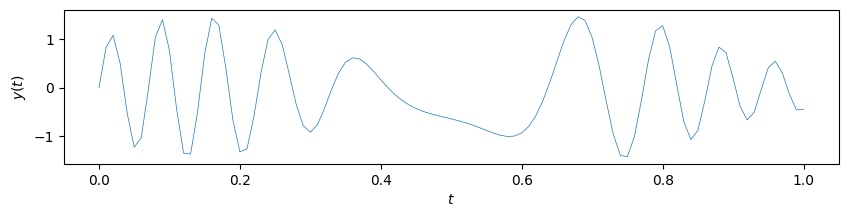

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# The following fcns operate on scalar `t` as well as on `np.ndarray` `t`. 
# If `t` is `np.ndarray`, the return value is `np.ndarray` as well.
a_fcn = lambda t: 1 + .5 * np.sin(11 * t)
freq0 = 30
freq1 = 5
theta_fcn = lambda t: freq0 * np.sin(freq1 * t)
y_fcn = lambda t: a_fcn(t) * np.sin(theta_fcn(t))

m = 101

t = np.linspace(0, 1, m)
y = y_fcn(t)

fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(t, y, linewidth=.5)
ax.set(xlabel='$t$', ylabel='$y(t)$')
plt.show()

## (1) Basis pursuit:

Solve $\Vert\cdot\Vert_1$-norm problem to obtain relevant heuristic sparsity pattern of the basis functions $f_{k, l, {\rm tri}}$ for the signal $y$.

In [2]:
K = 101
L = 30
dL1 = 2 * L + 1
KdL1 = K * dL1

sigma = .05
tau = np.linspace(0, 1, K)
omega_cos = np.linspace(0, freq1 * L, L+1)
omega_sin = np.linspace(0, freq1 * L, L+1)[1:]

# transpose so that t runs along axis 0
exp_fcn = lambda t: np.array([ np.exp(-((t - tau_k) / sigma) ** 2) for tau_k in tau ]).T
# Putting sines first lets us have the constants (i. e. frequency 0) in the middle at tri_fcn(t)[:, L]
tri_fcn = lambda t: np.concatenate([
    [ np.sin(omega_l * t) for omega_l in omega_sin ], 
    [ np.cos(omega_l * t) for omega_l in omega_cos ] 
], axis=0).T

exp = exp_fcn(t)
tri = tri_fcn(t)
A = np.array([
    np.outer(exp_i, tri_i)
    for exp_i, tri_i in zip(exp, tri)
])

gamma = cp.Parameter(nonneg=True)

A = A.reshape(m, KdL1)
x = cp.Variable( KdL1)
obj = cp.sum_squares( A @ x - y ) + gamma * cp.norm1(x)

problem = cp.Problem(cp.Minimize(obj))
gamma.value = 1
problem.solve(verbose=False)
x_opt_sparse = x.value

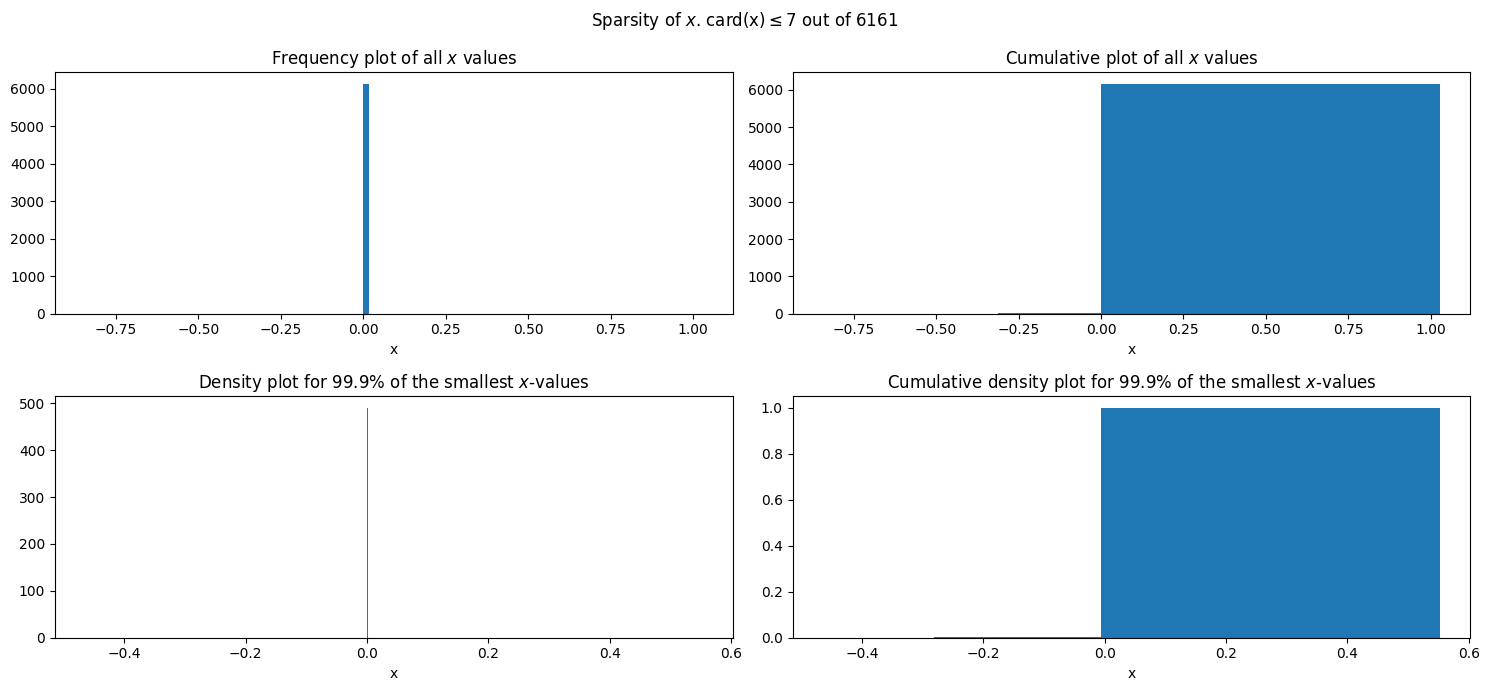

In [3]:
# Histogram plot of sparsity vector and approximation

# in second row only incluce a fraction of p smallest sparsity values into the histogram
p = .999 # also try p = .995, .99, .95, .90
nP = int(np.floor(p * KdL1))
nQ = KdL1 - nP
idx_smallest_p_rest = np.argpartition(np.abs(x_opt_sparse), nP)
idx_smallest_p = idx_smallest_p_rest[:nP]


fig, axes = plt.subplots(2, 2, figsize=(15, 7))
fig.suptitle(f'Sparsity of $x$. $\\rm{{card}}(x) \\leq { nQ } $ out of { KdL1 }')

ax = axes[0, 0]
ax.set(
    title=f'Frequency plot of all $x$ values',
    xlabel='x'
)
ax.hist(x_opt_sparse, bins=100)

ax = axes[0, 1]
ax.set(
    title=f'Cumulative plot of all $x$ values',
    xlabel='x'
)
ax.hist(x_opt_sparse, bins=500, cumulative=True)


ax = axes[1, 0]
ax.hist(x_opt_sparse[ idx_smallest_p ], bins=500, density=True)
ax.set(
    title=f'Density plot for ${{ { p * 100 } }} \\%$ of the smallest $x$-values',
    xlabel='x'
)

ax = axes[1, 1]
ax.set(
    title=f'Cumulative density plot for ${{ { p * 100 } }} \\%$ of the smallest $x$-values',
    xlabel='x'
)
ax.hist(x_opt_sparse[ idx_smallest_p ], bins=100, density=True, cumulative=True)

fig.tight_layout()
plt.show()

##### Remark on Performance

On an Apple M1 Pro the basis pursuit in step 1. with parameters 
* $\gamma = 1$
* $m = 501$ equidistant points in time $t_0, \ldots , t_{500}$
* $K = 501$ pulse centers $\tau_0, \ldots, \tau_{500}$ 
* $2 * L + 1 = 30 + 31 = 61$ frequencies $(\omega_0,) \omega_1, \ldots, \omega_{30}$

as found in [Boyd](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf) took about 5:30 minutes.

## (2) Solve Least-Squares with Sparsity Pattern from Step (1)

In [4]:
idx_greatest_1_p = np.setdiff1d(idx_smallest_p_rest, idx_smallest_p)
tilde_A = A[:, idx_greatest_1_p]

tilde_x = cp.Variable( nQ )
obj = cp.sum_squares(tilde_A @ tilde_x - y)
problem = cp.Problem(cp.Minimize(obj))
problem.solve(verbose=False)

tilde_x_opt_least_squares = tilde_x.value

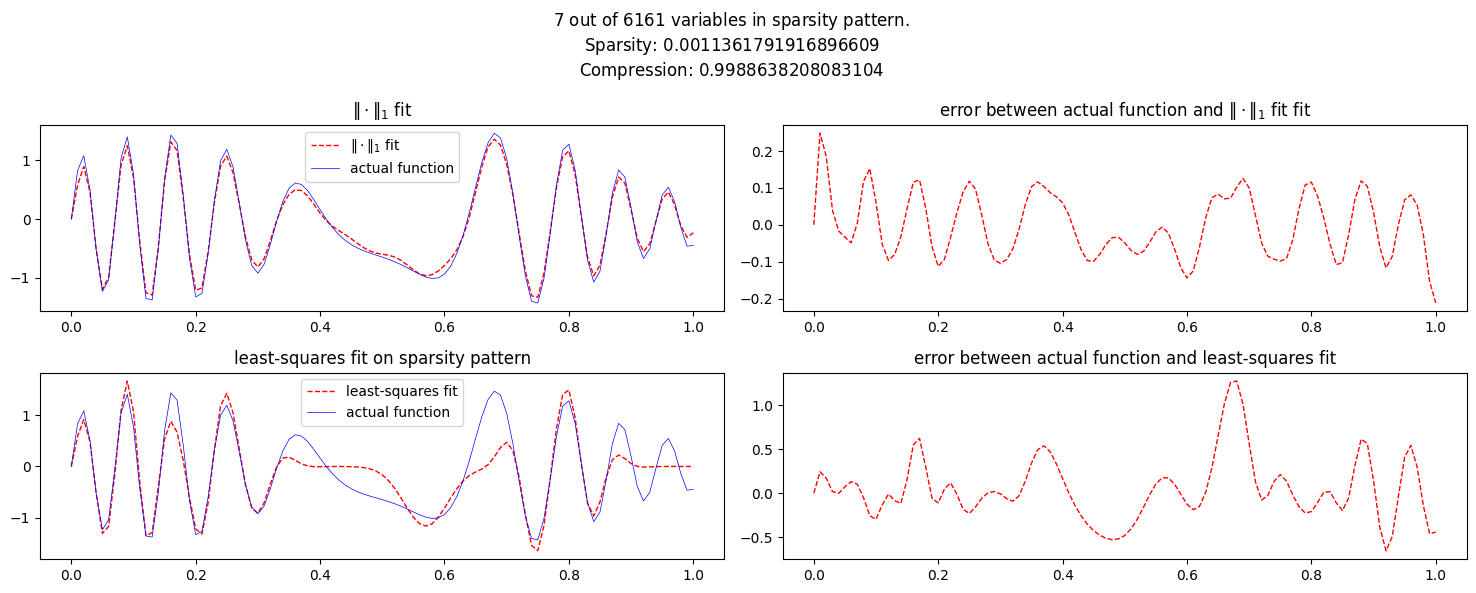

In [5]:
tilde_y = tilde_A @ tilde_x_opt_least_squares
sparse_y = A @ x_opt_sparse

fig, axes = plt.subplots(2, 2, figsize=(15, 6))

fig.suptitle(f'''$ { nQ } $ out of $ { KdL1 } $ variables in sparsity pattern. 
Sparsity: $ { nQ / KdL1 } $
Compression: $ { nP / KdL1 } $''')

ax = axes[0, 0]
ax.set(
    title=f'$\\Vert \\cdot \\Vert_1$ fit'
)
ax.plot(t, sparse_y, linewidth=1, color='red', linestyle='dashed', label='$\\Vert \\cdot \\Vert_1$ fit')
ax.plot(t, y, linewidth=.5, color='blue', label='actual function')
ax.legend()

ax = axes[0, 1]
ax.set(
    title=f'error between actual function and $\\Vert \\cdot \\Vert_1$ fit fit'
)
ax.plot(t, y - sparse_y, linewidth=1, color='red', linestyle='dashed')


ax = axes[1, 0]
ax.set(
    title=f'least-squares fit on sparsity pattern'
)
ax.plot(t, tilde_y, linewidth=1, color='red', linestyle='dashed', label='least-squares fit')
ax.plot(t, y, linewidth=.5, color='blue', label='actual function')
ax.legend()

ax = axes[1, 1]
ax.set(
    title=f'error between actual function and least-squares fit'
)
ax.plot(t, y - tilde_y, linewidth=1, color='red', linestyle='dashed')

fig.tight_layout()

plt.show()

First order approximation of frequency-phases $\theta(t)$ at pulse centers $\tau_k$

$$
\begin{align*}
\theta(t) \; &= \; \theta(\tau_k) + \theta^\prime(\tau_k) (t - \tau_k) \\
                \; &= \; 30 \sin(5\tau_k) - 150 \cos(5 \tau_k) \tau_k + 150 \cos(5 \tau_k) t \\
\omega(\tau_k) \; &= \; 150 \cos(5 \tau_k)
\end{align*}
$$

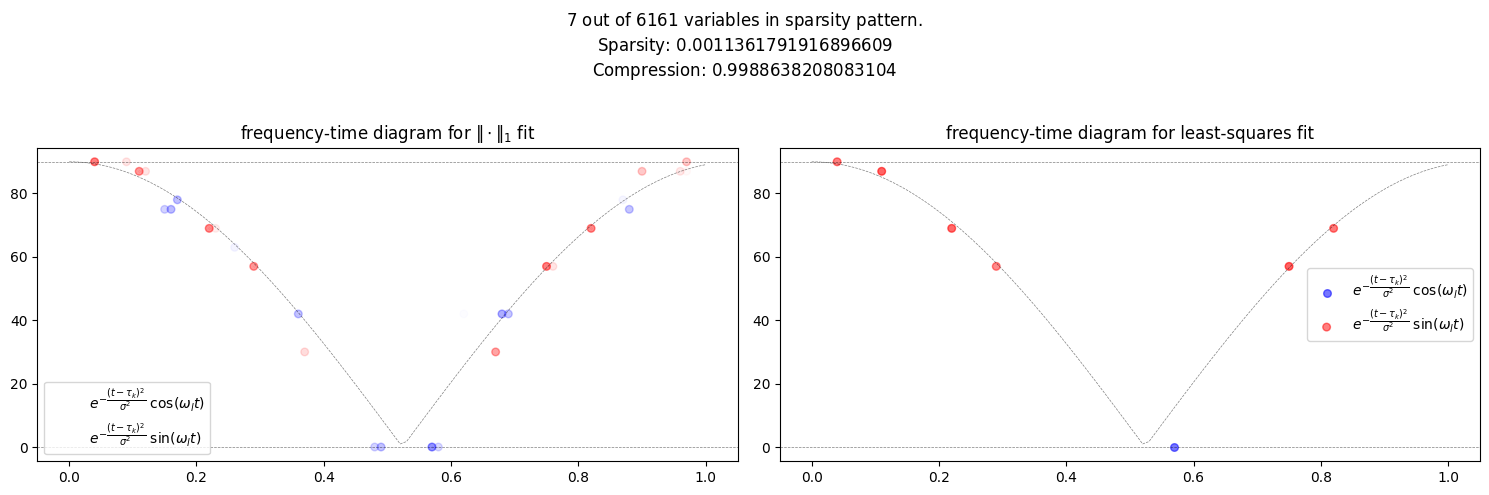

In [6]:
pattern_cos = idx_greatest_1_p[ idx_greatest_1_p % dL1 >= L ]
pattern_sin = idx_greatest_1_p[ idx_greatest_1_p % dL1 <  L ]

scatter_tau = np.array( [ np.ones(dL1) * tau_k for tau_k in tau ] ).reshape( KdL1 )

exact_frequencies = freq0 * freq1 * np.abs( np.cos( freq1 * tau ) )

base_cos = '$e^{-\\dfrac{(t-\\tau_k)^2}{\\sigma^2}} \\; \\cos(\\omega_l t)$'
base_sin = '$e^{-\\dfrac{(t-\\tau_k)^2}{\\sigma^2}} \\; \\sin(\\omega_l t)$'

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(f'''$ { nQ } $ out of $ { KdL1 } $ variables in sparsity pattern. 
Sparsity: $ { nQ / KdL1 } $
Compression: $ { nP / KdL1 } $
''')

# adapt scatter point size / alpha corresponding to a basis fcn
# by the value of sparse_x coefficient of that basis fcn
ax = axes[0]

ax.set(
    title='frequency-time diagram for $\\Vert \\cdot \\Vert_1$ fit'
)

# adapt scatter points' [ size | alpha | color ]s to absolute values of sparsity coefficients

intensity_cos = 1 - 1 / ( 1 + np.abs( x_opt_sparse.reshape(K, dL1)[:, L: ].reshape(K * (L+1)) ) )
intensity_sin = 1 - 1 / ( 1 + np.abs( x_opt_sparse.reshape(K, dL1)[:,  :L].reshape(K *  L   ) ) )

# background grid cosine and sine
ax.scatter( scatter_tau[pattern_cos], freq1 * (pattern_cos % dL1 - L), s=.01, color='blue', alpha=.5 )
ax.scatter( scatter_tau[pattern_sin], freq1 * (pattern_sin % dL1 + 1), s=.01, color='red' , alpha=.5 )
# visualization of sparsity coefficients
ax.scatter(
    scatter_tau.reshape(K, dL1)[:, L:].reshape(K * (L+1)), 
    freq1 * np.array( np.tile( np.arange(0, L + 1 ), K ) ), 
    s=30, color='blue', alpha=intensity_cos, label=base_cos
)
ax.scatter(
    scatter_tau.reshape(K, dL1)[:, :L].reshape(K * L), 
    freq1 * np.array( np.tile( np.arange(0, L) + 1, K ) ), 
    s=30, color='red' , alpha=intensity_sin, label=base_sin
)

ax.axhline( freq1 * L, color='black', alpha=.5, linewidth=.5, linestyle='dashed')
ax.axhline( 0        , color='black', alpha=.5, linewidth=.5, linestyle='dashed')
ax.plot(tau,  exact_frequencies, color='black', alpha=.5, linewidth=.5, linestyle='dashed')
ax.legend()


ax = axes[1]
ax.set(
    title='frequency-time diagram for least-squares fit'
)

x_fit_cos = tilde_x_opt_least_squares[idx_greatest_1_p % dL1 >= L]
x_fit_sin = tilde_x_opt_least_squares[idx_greatest_1_p % dL1 <  L]

# adapt scatter points' [ size | alpha | color ]s to absolute values of sparsity coefficients

intensity_cos_fit = 1 - 1 / ( 1 + np.abs( x_fit_cos ) )
intensity_sin_fit = 1 - 1 / ( 1 + np.abs( x_fit_sin ) )

# background grid
# ax.scatter(
#     scatter_tau.reshape(K, dL1)[:, L:].reshape(K * (L+1)), 
#     freq1 * np.array([ np.arange(0, L+1)   for tau_k in tau ]), 
#     s=.05, color='black', alpha=.15
# )
# visualization of least-squares fit on sparsity pattern
ax.scatter(
    scatter_tau[pattern_cos], 
    freq1 * (pattern_cos % dL1 - L), 
    s=30, color='blue', alpha=intensity_cos_fit, label=base_cos
)
ax.scatter(
    scatter_tau[pattern_sin], 
    freq1 * (pattern_sin % dL1 + 1), 
    s=30, color='red' , alpha=intensity_sin_fit, label=base_sin
)

ax.axhline( freq1 * L, color='black', alpha=.5, linewidth=.5, linestyle='dashed')
ax.axhline( 0        , color='black', alpha=.5, linewidth=.5, linestyle='dashed')
ax.plot(tau,  exact_frequencies, color='black', alpha=.5, linewidth=.5, linestyle='dashed')
ax.legend()

fig.tight_layout()
plt.show()